# Summary

1) In March, a large negative change in conversions occured and should be investigated further.
2) For Mobile devices, the conversion rate from the home page to the search page dropped dramatically for both genders, i.e. Mobile users failed to move from the home page to the search page.
3) For Desktop users, the conversion rate from the search page to the payment page dropped, i.e. Desktop users were getting to the search page at normal rates, but then failed to get to the payment page.

We should investigate whether these are separate problems.

In [2]:
# Load useful packages
import seaborn as sns
from pandas import Series,DataFrame
import pandas as pd
import matplotlib as mpl
import numpy as np
import random as rnd

import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')
print(alt.renderers.active)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

from scipy import sparse
import io


notebook


In [3]:
# load all csv's
dtype = {
    'user_id' : 'int',
    'date'    : 'str',
    'device'  : 'category',
    'sex'     : 'category'
}
raw_data_user = pd.read_csv('Crunchbase/Crunchbase_Startup_Investment_Data.csv', dtype=dtype, parse_dates=['date'])
dtype = {
    'user_id' : 'int',
    'page'    : 'category'
}
raw_data_hp   = pd.read_csv('FunnelData/home_page_table.csv', dtype=dtype)
raw_data_sea  = pd.read_csv('FunnelData/search_page_table.csv', dtype=dtype)
raw_data_pay  = pd.read_csv('FunnelData/payment_page_table.csv', dtype=dtype)
raw_data_conf = pd.read_csv('FunnelData/payment_confirmation_table.csv', dtype=dtype)

In [4]:
# check unique values for the pages
# sum(raw_data_conf['page']!='payment_confirmation_page')
df = pd.merge(raw_data_user,raw_data_hp,on='user_id',how='left')
df.rename(columns={'page':'home'},inplace=True)
df['home']=df['home']=='home_page'

df = pd.merge(df,raw_data_sea,on='user_id',how='left')
df.rename(columns={'page':'search'},inplace=True)
df['search']=df['search']=='search_page'

df = pd.merge(df,raw_data_pay,on='user_id',how='left')
df.rename(columns={'page':'payment'},inplace=True)
df['payment']=df['payment']=='payment_page'

df = pd.merge(df,raw_data_conf,on='user_id',how='left')
df.rename(columns={'page':'conf'},inplace=True)
df['conf']=df['conf']=='payment_confirmation_page'

df.drop(['user_id'],axis=1,inplace=True)
df.head(10)


,date,device,sex,home,search,payment,conf
0,2015-02-28,Desktop,Female,True,False,False,False
1,2015-01-13,Desktop,Male,True,False,False,False
2,2015-04-09,Desktop,Male,True,True,False,False
3,2015-02-18,Desktop,Female,True,True,False,False
4,2015-01-15,Desktop,Male,True,False,False,False
5,2015-03-03,Desktop,Male,True,False,False,False
6,2015-04-15,Desktop,Female,True,True,False,False
7,2015-01-27,Mobile,Male,True,False,False,False
8,2015-04-12,Desktop,Female,True,False,False,False
9,2015-02-24,Mobile,Female,True,True,False,False


## Overall conversion rates



In [5]:
total = len(df)
print('visitors:',sum(df['home']))
print('Home to Search  Page:',round(100*sum(df['search'])/total,2),'%')
print('Home to Payment Page:',round(100*sum(df['payment'])/total,2),'%',' Search to Payment:',round(100*sum(df['payment'])/sum(df['search']),2))
print('Home to Confrimation:',round(100*sum(df['conf'])/total,2),'%',' Payment to Confirm:',round(100*sum(df['conf'])/sum(df['payment']),2))



visitors: 90400
Home to Search  Page: 50.0 %
Home to Payment Page: 6.67 %  Search to Payment: 13.34
Home to Confrimation: 0.5 %  Payment to Confirm: 7.5


## Large-scale Groupings



                   home   search payment   conf
                    sum      sum     sum    sum
sex    device                                  
Female Desktop  29997.0  15091.0  1530.0   74.0
       Mobile   15078.0   7585.0  1570.0  167.0
Male   Desktop  30203.0  15009.0  1480.0   76.0
       Mobile   15122.0   7515.0  1450.0  135.0


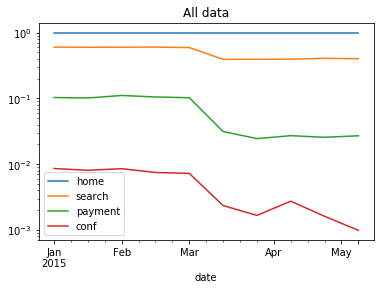

In [6]:
x = df.groupby(['sex','device']).agg(['sum'])
print(x)
#df[['payment','conf']].groupby(pd.Grouper(key='date', freq='W')).mean()#.plot(title='All data')
ax=df.groupby(pd.Grouper(key='date', freq='2W')).mean().plot(title='All data')
ax.set_yscale('log')


### Observations

- Mobile users of both genders get to the payments page at higher rates
- The rate at which payments convert to confirmations are smaller in Desktop (5% rather than 10% in Mobile)
- There are only about half as many Mobile visitors as Desktop visitors

## Time Analysis

Plot all rates versus date; segment by gender and device.




                           home    search   payment      conf
sex    device  date                                          
Female Desktop 2015-01-04   1.0  0.508421  0.077895  0.003158
               2015-01-11   1.0  0.507993  0.069864  0.004144
               2015-01-18   1.0  0.519952  0.083979  0.004765
               2015-01-25   1.0  0.493395  0.087306  0.004595
               2015-02-01   1.0  0.523190  0.090498  0.004525


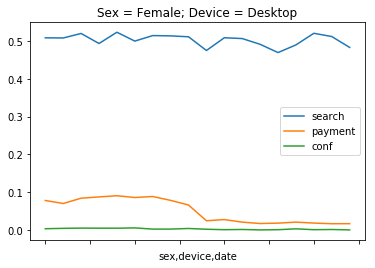

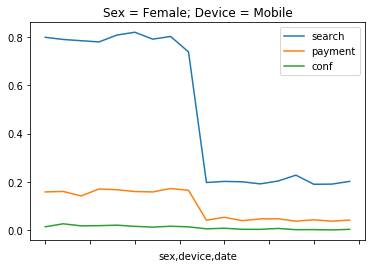

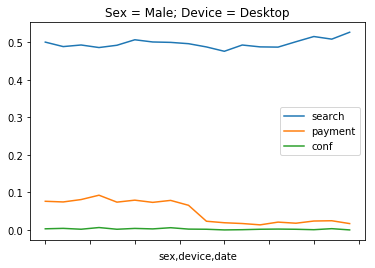

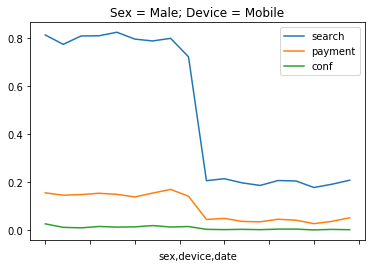

In [7]:
grouped = df.groupby(['sex','device',pd.Grouper(key='date', freq='W')])
groupedmean = grouped.mean()

print(groupedmean.head())
for sex in groupedmean.index.levels[0]:
    for device in groupedmean.index.levels[1]:
        title = 'Sex = ' + sex + '; Device = ' + device
        ax=groupedmean[['search','payment','conf']].loc[sex,device,:].plot(title=title)
        #ax.set_yscale('log')
        #ax.set_ylim([.00001,1])


In [19]:
# Just for fun, try grouping other ways
grouped = df.groupby([pd.Grouper(key='date', freq='W'),'sex','device'])
groupedmean = grouped.mean()

print((groupedmean.unstack().unstack()))
# Yup that works.
# How would altair look?

# import altair as alt
# alt.Chart(groupedmean).mark_line().encode(
#     x='date:T',
#     y='search:Q'
# )


              home                     search                                \
device     Desktop      Mobile        Desktop              Mobile             
sex         Female Male Female Male    Female      Male    Female      Male   
date                                                                          
2015-01-04     1.0  1.0    1.0  1.0  0.508421  0.500992  0.798780  0.813596   
2015-01-11     1.0  1.0    1.0  1.0  0.507993  0.489047  0.789838  0.774614   
2015-01-18     1.0  1.0    1.0  1.0  0.519952  0.493301  0.784667  0.809409   
2015-01-25     1.0  1.0    1.0  1.0  0.493395  0.486486  0.779623  0.810263   
2015-02-01     1.0  1.0    1.0  1.0  0.523190  0.492590  0.808092  0.824971   
2015-02-08     1.0  1.0    1.0  1.0  0.499735  0.507239  0.819724  0.796375   
2015-02-15     1.0  1.0    1.0  1.0  0.514379  0.501351  0.791221  0.788687   
2015-02-22     1.0  1.0    1.0  1.0  0.513572  0.500268  0.802186  0.799595   
2015-03-01     1.0  1.0    1.0  1.0  0.511172  0.496

## Conclusions:

1) There is a huge dropoff starting in March in going to the search page for both genders on the Mobile platform.  



## Funnel Rate Analysis

For this, we won't just look at the raw rates to each site, but rather look at the conversion from one level to the next.  I.e. what percentage of 

### Post-Search Page

                           home  search   payment      conf
sex    device  date                                        
Female Desktop 2015-01-04   1.0     1.0  0.153209  0.006211
               2015-01-11   1.0     1.0  0.137529  0.008159
               2015-01-18   1.0     1.0  0.161512  0.009164
               2015-01-25   1.0     1.0  0.176950  0.009313
               2015-02-01   1.0     1.0  0.172973  0.008649


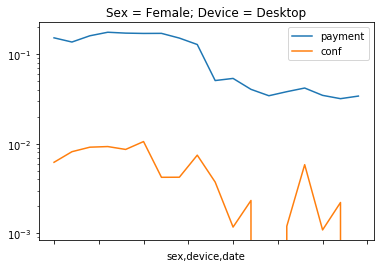

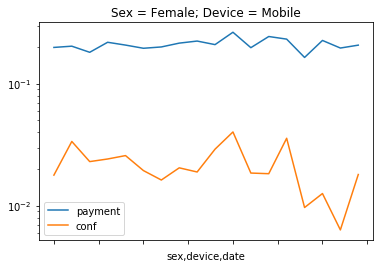

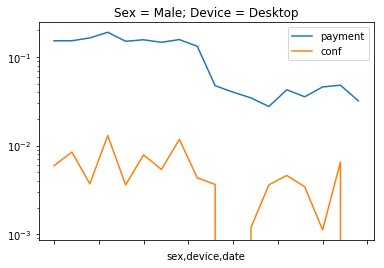

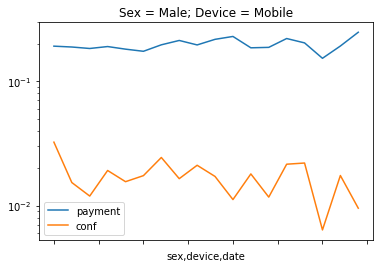

In [210]:
# create a payment conversion subset df
dfsea = df[df['search']]

groupedmean = dfsea.groupby(['sex','device',pd.Grouper(key='date', freq='W')]).mean()
print(groupedmean.head())
for sex in groupedmean.index.levels[0]:
    for device in groupedmean.index.levels[1]:
        title = 'Sex = ' + sex + '; Device = ' + device
        ax=groupedmean[['payment','conf']].loc[sex,device,:].plot(title=title)
        ax.set_yscale('log')



### Post-search conclusion:

2) The Desktop (but not movile) payment funnel rate seems to drop around the same time, beginning of March, i.e. Desktop users are getting to the search page but not then getting to the payment page.



### Post payment page

                           home  search   payment      conf
sex    device  date                                        
Female Desktop 2015-01-04   1.0     1.0  0.153209  0.006211
               2015-02-01   1.0     1.0  0.162447  0.008819
               2015-03-01   1.0     1.0  0.156250  0.006621
               2015-03-29   1.0     1.0  0.045032  0.001801
               2015-04-26   1.0     1.0  0.036669  0.002558


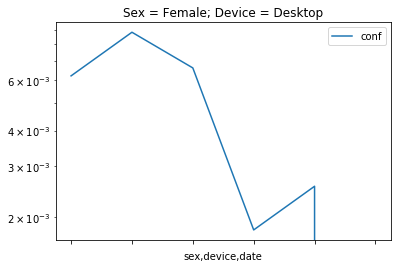

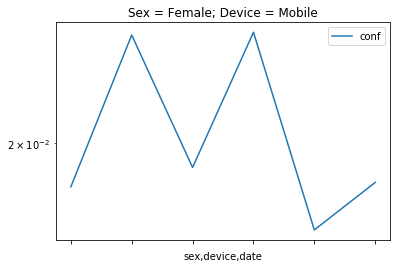

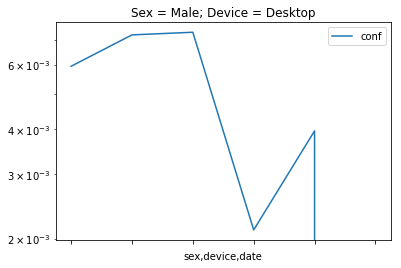

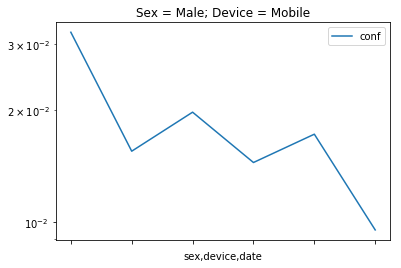

In [211]:
# create a payment conversion subset df
dfpay = df[df['payment']]

groupedmean = dfsea.groupby(['sex','device',pd.Grouper(key='date', freq='4W')]).mean()
print(groupedmean.head())
for sex in groupedmean.index.levels[0]:
    for device in groupedmean.index.levels[1]:
        title = 'Sex = ' + sex + '; Device = ' + device
        ax=groupedmean[['conf']].loc[sex,device,:].plot(title=title)
        ax.set_yscale('log')


### Funnel Conclusions:

Within the limits of the data (poor statistics) it is hard to say whether these funnel rates have changed.  